# Workshop Session 3: Global Machine Learning Models for Time Series Forecasting

## Welcome to Session 3!

In Session 2, we explored **local ML models** - training one separate model per time series. Now we'll learn about **global models** - training a single model across all time series!

### What You'll Learn:
1. **Global ML Models** - training one model across all time series
2. **Global Data Preparation** - creating training datasets for multiple series
3. **Model-Specific Lag Selection** - finding optimal lags for each algorithm
4. **Feature Engineering** - normalization and date features for LightGBM
5. **Loss Function Tuning** - comparing different objectives for LightGBM
6. **Performance Comparison** - global vs local approaches

Let's get started!

## What Are Global ML Models?

### Local Models (Session 2):
- Train **one model per time series**
- Example: 10 stores → 10 separate models
- Each model learns only from its own history

### Global Models (Session 3):
- Train **one model across all time series**
- Example: 10 stores → 1 shared model
- Model learns patterns across all series

### Advantages of Global Models:
- ✅ **Cross-learning**: Learns patterns from similar series
- ✅ **Data efficiency**: Especially useful when individual series are short
- ✅ **Scalability**: One model for thousands of series (vs thousands of models)
- ✅ **Faster inference**: One prediction call instead of N calls

### The Challenge:
How do we combine multiple time series into a single training dataset?

**Answer**: Stack them together with lagged features for each series!

## 1. Setup and Imports

In [27]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Plotting
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load Data and Train/Test Split

We'll use the same M5 food sales dataset from previous sessions.

In [28]:
# Load the data
data_path = "/home/filtheo/Cloud-for-AI/workshop_ml_2025/data/converted_df.csv"
df = pd.read_csv(data_path, parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"Number of stores: {df['unique_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (12100, 3)
Number of stores: 10
Date range: 2013-01-01 00:00:00 to 2016-04-24 00:00:00

First few rows:


,unique_id,date,y
0,CA_1,2013-01-01,1888
1,CA_2,2013-01-01,1320
2,CA_3,2013-01-01,2454
3,CA_4,2013-01-01,1031
4,TX_1,2013-01-01,1607
5,TX_2,2013-01-01,2469
6,TX_3,2013-01-01,1773
7,WI_1,2013-01-01,1365
8,WI_2,2013-01-01,1506
9,WI_3,2013-01-01,1415


In [29]:
# Train/Test Split: Same as Session 2 (last 14 days for testing)
test_size = 14
max_date = df['date'].max()
split_date = max_date - pd.Timedelta(days=test_size - 1)

df_train = df[df['date'] < split_date].copy()
df_test = df[df['date'] >= split_date].copy()

print(f"Train/Test Split:")
print("=" * 60)
print(f"Training set: {len(df_train):,} observations")
print(f"Test set: {len(df_test):,} observations")
print(f"\nDate ranges:")
print(f"  Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Test:  {df_test['date'].min()} to {df_test['date'].max()}")
print(f"\nForecast horizon: {test_size} days")

# Store list
stores = df['unique_id'].unique()
print(f"\nStores: {list(stores)}")

Train/Test Split:
Training set: 11,960 observations
Test set: 140 observations

Date ranges:
  Train: 2013-01-01 00:00:00 to 2016-04-10 00:00:00
  Test:  2016-04-11 00:00:00 to 2016-04-24 00:00:00

Forecast horizon: 14 days

Stores: ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']


## 3. Global Data Preparation

### The Key Difference: Global vs Local

**Local approach (Session 2)**:
- Create lagged features for CA_1 → Train model 1
- Create lagged features for CA_2 → Train model 2
- ...

**Global approach (Session 3)**:
- Create lagged features for ALL stores
- **Stack** them into one big dataset
- Train ONE model on the combined data

### Visual Example:

```
Store CA_1:  lag_1  lag_2  lag_3  target
             2813   2508   1888   3124
             3124   2813   2508   2956

Store CA_2:  lag_1  lag_2  lag_3  target
             1622   1587   1320   1589
             1589   1622   1587   1456

         ↓ STACK ↓

Global:  unique_id  lag_1  lag_2  lag_3  target
         CA_1       2813   2508   1888   3124
         CA_1       3124   2813   2508   2956
         CA_2       1622   1587   1320   1589
         CA_2       1589   1622   1587   1456
```

Let's implement this!

In [30]:
def create_global_training_dataset(df, max_lags):
    """
    Create a global training dataset with lagged features for all time series.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with columns: ['unique_id', 'date', 'y']
    max_lags : int
        Maximum number of lags to create (creates lags 1 to max_lags)
    
    Returns:
    --------
    DataFrame with lagged features for all series combined
    """
    all_series_data = []
    
    for unique_id in df['unique_id'].unique():
        # Get data for this series
        series_data = df[df['unique_id'] == unique_id].sort_values('date').copy()
        
        # Create lagged features
        for lag in range(1, max_lags + 1):
            series_data[f'lag_{lag}'] = series_data['y'].shift(lag)
        
        # Target is current value
        series_data['target'] = series_data['y']
        
        # Drop rows with NaN (from lag creation)
        series_data = series_data.dropna()
        
        all_series_data.append(series_data)
    
    # Combine all series
    global_data = pd.concat(all_series_data, ignore_index=True)
    
    return global_data

print("✅ Function created: create_global_training_dataset()")

✅ Function created: create_global_training_dataset()


### Example: Create Global Dataset

In [31]:
# Create global training dataset with max_lags=7
global_train = create_global_training_dataset(df_train, max_lags=7)

print("Global Training Dataset:")
print("=" * 60)
print(f"Shape: {global_train.shape}")
print(f"Columns: {list(global_train.columns)}")
print(f"\nNumber of unique stores: {global_train['unique_id'].nunique()}")
print(f"\nFirst 10 rows:")
global_train.head(10)

Global Training Dataset:
Shape: (11890, 11)
Columns: ['unique_id', 'date', 'y', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'target']

Number of unique stores: 10

First 10 rows:


,unique_id,date,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,target
0,CA_1,2013-01-08,2449,2847.0,3557.0,3320.0,2962.0,2813.0,2508.0,1888.0,2449
1,CA_1,2013-01-09,2118,2449.0,2847.0,3557.0,3320.0,2962.0,2813.0,2508.0,2118
2,CA_1,2013-01-10,2543,2118.0,2449.0,2847.0,3557.0,3320.0,2962.0,2813.0,2543
3,CA_1,2013-01-11,2837,2543.0,2118.0,2449.0,2847.0,3557.0,3320.0,2962.0,2837
4,CA_1,2013-01-12,3694,2837.0,2543.0,2118.0,2449.0,2847.0,3557.0,3320.0,3694
5,CA_1,2013-01-13,3351,3694.0,2837.0,2543.0,2118.0,2449.0,2847.0,3557.0,3351
6,CA_1,2013-01-14,2295,3351.0,3694.0,2837.0,2543.0,2118.0,2449.0,2847.0,2295
7,CA_1,2013-01-15,2194,2295.0,3351.0,3694.0,2837.0,2543.0,2118.0,2449.0,2194
8,CA_1,2013-01-16,1992,2194.0,2295.0,3351.0,3694.0,2837.0,2543.0,2118.0,1992
9,CA_1,2013-01-17,2150,1992.0,2194.0,2295.0,3351.0,3694.0,2837.0,2543.0,2150


In [32]:
# Check data distribution across stores
print("\nRows per store:")
print(global_train['unique_id'].value_counts().sort_index())
print(f"\n💡 Notice: All stores have the same number of rows (after removing NaN from lags)")


Rows per store:
unique_id
CA_1    1189
CA_2    1189
CA_3    1189
CA_4    1189
TX_1    1189
TX_2    1189
TX_3    1189
WI_1    1189
WI_2    1189
WI_3    1189
Name: count, dtype: int64

💡 Notice: All stores have the same number of rows (after removing NaN from lags)


## 4. Lag Selection via Cross-Validation

### Finding Optimal Lags for Each Model

Different models may perform best with different lag configurations!

- **Linear Regression**: May prefer fewer lags (simpler model)
- **Random Forest**: Can handle more lags (captures interactions)
- **LightGBM**: Often works well with more lags (powerful gradient boosting)

We'll test: `[3, 7, 14, 21, 28]` for each model separately.

In [33]:
def global_cv_lag_selection(df_train, max_lags_candidates, model_type='linear', n_folds=3, h=7):
    """
    Perform time series cross-validation to select optimal max_lags for global model.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data with all series
    max_lags_candidates : list
        List of max_lags values to test
    model_type : str
        Type of model ('linear', 'rf', 'lgbm')
    n_folds : int
        Number of CV folds
    h : int
        Validation horizon (days to forecast in each fold)
    
    Returns:
    --------
    dict : validation MSE for each max_lags candidate
    """
    results = {max_lags: [] for max_lags in max_lags_candidates}
    stores = df_train['unique_id'].unique()
    
    for fold in range(n_folds):
        print(f"  Fold {fold + 1}/{n_folds}...")
        
        # Create fold data for all stores
        fold_train_list = []
        fold_val_list = []
        
        for store in stores:
            store_data = df_train[df_train['unique_id'] == store].sort_values('date').reset_index(drop=True)
            
            total_len = len(store_data)
            val_end = total_len - (n_folds - fold - 1) * h
            val_start = val_end - h
            train_end = val_start
            
            fold_train_list.append(store_data.iloc[:train_end])
            fold_val_list.append(store_data.iloc[val_start:val_end])
        
        fold_train_df = pd.concat(fold_train_list, ignore_index=True)
        fold_val_df = pd.concat(fold_val_list, ignore_index=True)
        
        # Test each max_lags candidate
        for max_lags in max_lags_candidates:
            # Create global training dataset
            train_lagged = create_global_training_dataset(fold_train_df, max_lags=max_lags)
            
            # Prepare features
            feature_cols = [col for col in train_lagged.columns if col.startswith('lag_')]
            X = train_lagged[feature_cols]
            y = train_lagged['target']
            
            # Train model
            if model_type == 'linear':
                model = LinearRegression()
            elif model_type == 'rf':
                model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
            elif model_type == 'lgbm':
                model = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42, verbose=-1)
            else:
                raise ValueError(f"Unknown model_type: {model_type}")
            
            model.fit(X, y)
            
            # Generate forecasts for all stores
            all_forecasts = []
            all_actuals = []
            
            for store in stores:
                # Get last observations from training fold
                store_train = fold_train_df[fold_train_df['unique_id'] == store].sort_values('date')
                last_obs = store_train['y'].values[-max_lags:]
                
                # Recursive forecasting
                history = list(last_obs)
                forecasts = []
                
                for step in range(h):
                    X_forecast = np.array(history[-max_lags:]).reshape(1, -1)
                    y_pred = model.predict(X_forecast)[0]
                    forecasts.append(y_pred)
                    history.append(y_pred)
                
                all_forecasts.extend(forecasts)
                
                # Get actual values
                store_val = fold_val_df[fold_val_df['unique_id'] == store].sort_values('date')
                all_actuals.extend(store_val['y'].values)
            
            # Calculate MSE across all stores
            mse = mean_squared_error(all_actuals, all_forecasts)
            results[max_lags].append(mse)
    
    # Average across folds
    avg_results = {max_lags: np.mean(mses) for max_lags, mses in results.items()}
    
    return avg_results

print("✅ Function created: global_cv_lag_selection()")

✅ Function created: global_cv_lag_selection()


### Find Optimal Lags for Linear Regression

In [34]:
max_lags_candidates = [3, 7, 14, 21, 28]

print("Running cross-validation for Linear Regression...")
cv_results_lr = global_cv_lag_selection(
    df_train, max_lags_candidates, model_type='linear', n_folds=3, h=7
)

print("\nCross-Validation Results for Linear Regression:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_lr.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

best_lags_lr = min(cv_results_lr, key=cv_results_lr.get)
print(f"\n✅ Optimal max_lags for Linear Regression: {best_lags_lr}")
print(f"   Validation MSE: {cv_results_lr[best_lags_lr]:.2f}")

Running cross-validation for Linear Regression...
  Fold 1/3...
  Fold 2/3...
  Fold 3/3...

Cross-Validation Results for Linear Regression:
  max_lags= 3 → Validation MSE: 602966.74
  max_lags= 7 → Validation MSE: 424890.90
  max_lags=14 → Validation MSE: 665354.88
  max_lags=21 → Validation MSE: 619265.04
  max_lags=28 → Validation MSE: 412255.85

✅ Optimal max_lags for Linear Regression: 28
   Validation MSE: 412255.85


### Find Optimal Lags for Random Forest

In [35]:
print("Running cross-validation for Random Forest...")
cv_results_rf = global_cv_lag_selection(
    df_train, max_lags_candidates, model_type='rf', n_folds=3, h=7
)

print("\nCross-Validation Results for Random Forest:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_rf.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

best_lags_rf = min(cv_results_rf, key=cv_results_rf.get)
print(f"\n✅ Optimal max_lags for Random Forest: {best_lags_rf}")
print(f"   Validation MSE: {cv_results_rf[best_lags_rf]:.2f}")

Running cross-validation for Random Forest...
  Fold 1/3...
  Fold 2/3...
  Fold 3/3...

Cross-Validation Results for Random Forest:
  max_lags= 3 → Validation MSE: 732187.05
  max_lags= 7 → Validation MSE: 466351.90
  max_lags=14 → Validation MSE: 560004.57
  max_lags=21 → Validation MSE: 546091.52
  max_lags=28 → Validation MSE: 450147.43

✅ Optimal max_lags for Random Forest: 28
   Validation MSE: 450147.43


### Find Optimal Lags for LightGBM

In [36]:
print("Running cross-validation for LightGBM...")
cv_results_lgbm = global_cv_lag_selection(
    df_train, max_lags_candidates, model_type='lgbm', n_folds=3, h=7
)

print("\nCross-Validation Results for LightGBM:")
print("=" * 50)
for max_lags, mse in sorted(cv_results_lgbm.items()):
    print(f"  max_lags={max_lags:2d} → Validation MSE: {mse:.2f}")

best_lags_lgbm = min(cv_results_lgbm, key=cv_results_lgbm.get)
print(f"\n✅ Optimal max_lags for LightGBM: {best_lags_lgbm}")
print(f"   Validation MSE: {cv_results_lgbm[best_lags_lgbm]:.2f}")

Running cross-validation for LightGBM...
  Fold 1/3...
  Fold 2/3...
  Fold 3/3...

Cross-Validation Results for LightGBM:
  max_lags= 3 → Validation MSE: 693916.99
  max_lags= 7 → Validation MSE: 476281.75
  max_lags=14 → Validation MSE: 623913.27
  max_lags=21 → Validation MSE: 574643.15
  max_lags=28 → Validation MSE: 430475.73

✅ Optimal max_lags for LightGBM: 28
   Validation MSE: 430475.73


### Visualize Lag Selection Results

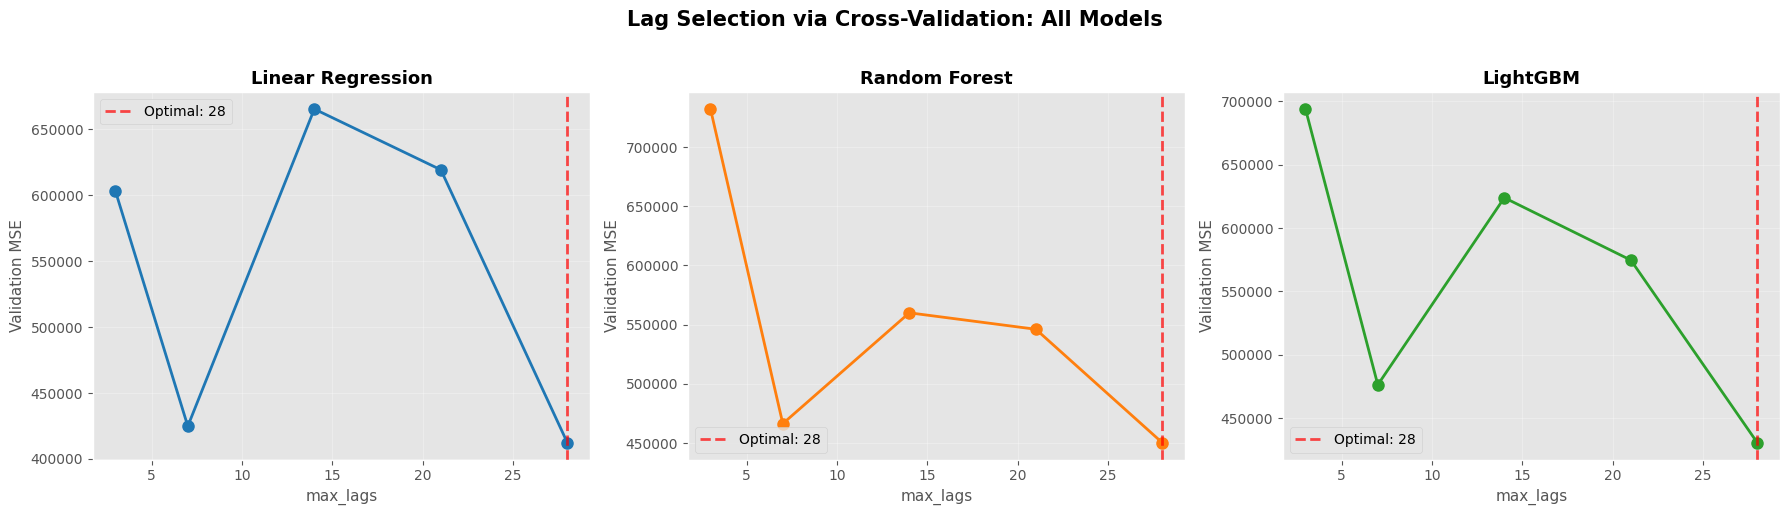


💡 Summary:
  Linear Regression optimal lags: 28
  Random Forest optimal lags: 28
  LightGBM optimal lags: 28


In [37]:
# Plot validation MSE vs max_lags for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear Regression
lags_list = sorted(cv_results_lr.keys())
mse_list_lr = [cv_results_lr[lag] for lag in lags_list]
axes[0].plot(lags_list, mse_list_lr, marker='o', linewidth=2, markersize=8, color='#1f77b4')
axes[0].axvline(x=best_lags_lr, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Optimal: {best_lags_lr}')
axes[0].set_xlabel('max_lags', fontsize=11)
axes[0].set_ylabel('Validation MSE', fontsize=11)
axes[0].set_title('Linear Regression', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Random Forest
mse_list_rf = [cv_results_rf[lag] for lag in lags_list]
axes[1].plot(lags_list, mse_list_rf, marker='o', linewidth=2, markersize=8, color='#ff7f0e')
axes[1].axvline(x=best_lags_rf, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Optimal: {best_lags_rf}')
axes[1].set_xlabel('max_lags', fontsize=11)
axes[1].set_ylabel('Validation MSE', fontsize=11)
axes[1].set_title('Random Forest', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# LightGBM
mse_list_lgbm = [cv_results_lgbm[lag] for lag in lags_list]
axes[2].plot(lags_list, mse_list_lgbm, marker='o', linewidth=2, markersize=8, color='#2ca02c')
axes[2].axvline(x=best_lags_lgbm, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Optimal: {best_lags_lgbm}')
axes[2].set_xlabel('max_lags', fontsize=11)
axes[2].set_ylabel('Validation MSE', fontsize=11)
axes[2].set_title('LightGBM', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Lag Selection via Cross-Validation: All Models', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n💡 Summary:")
print(f"  Linear Regression optimal lags: {best_lags_lr}")
print(f"  Random Forest optimal lags: {best_lags_rf}")
print(f"  LightGBM optimal lags: {best_lags_lgbm}")

## 5. Train All Models with Their Optimal Lags

Now let's train each model with its optimal lag configuration and generate forecasts!

In [ ]:
def train_global_model_and_forecast(df_train, df_test, max_lags, h, model_type='linear'):
    """
    Train a global model and generate forecasts for all stores.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data
    df_test : DataFrame
        Test data
    max_lags : int
        Maximum number of lags
    h : int
        Forecast horizon
    model_type : str
        Type of model ('linear', 'rf', 'lgbm')
    
    Returns:
    --------
    dict : forecasts for each store
    """
    # Create global training dataset
    train_lagged = create_global_training_dataset(df_train, max_lags=max_lags)
    
    # Prepare features
    feature_cols = [col for col in train_lagged.columns if col.startswith('lag_')]
    X = train_lagged[feature_cols]
    y = train_lagged['target']
    
    # Train model
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'rf':
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif model_type == 'lgbm':
        model = lgb.LGBMRegressor(random_state=42, verbose=-1)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    model.fit(X, y)
    
    # Generate forecasts for all stores
    forecasts_dict = {}
    stores = df_train['unique_id'].unique()
    
    for store in stores:
        # Get last observations
        store_train = df_train[df_train['unique_id'] == store].sort_values('date')
        last_obs = store_train['y'].values[-max_lags:]
        
        # Recursive forecasting
        history = list(last_obs)
        forecasts = []
        
        for step in range(h):
            X_forecast = np.array(history[-max_lags:]).reshape(1, -1)
            y_pred = model.predict(X_forecast)[0]
            forecasts.append(y_pred)
            history.append(y_pred)
        
        forecasts_dict[store] = np.array(forecasts)
    
    return forecasts_dict

print("✅ Function created: train_global_model_and_forecast()")

✅ Function created: train_global_model_and_forecast()


In [39]:
# Train all models with their optimal lags
print("Training all models with optimal lags...\n")

# Linear Regression
print(f"  Training Linear Regression (max_lags={best_lags_lr})...")
forecasts_lr = train_global_model_and_forecast(
    df_train, df_test, max_lags=best_lags_lr, h=test_size, model_type='linear'
)

# Random Forest
print(f"  Training Random Forest (max_lags={best_lags_rf})...")
forecasts_rf = train_global_model_and_forecast(
    df_train, df_test, max_lags=best_lags_rf, h=test_size, model_type='rf'
)

# LightGBM
print(f"  Training LightGBM (max_lags={best_lags_lgbm})...")
forecasts_lgbm = train_global_model_and_forecast(
    df_train, df_test, max_lags=best_lags_lgbm, h=test_size, model_type='lgbm'
)

print("\n✅ All models trained and forecasted!")

Training all models with optimal lags...

  Training Linear Regression (max_lags=28)...
  Training Random Forest (max_lags=28)...
  Training LightGBM (max_lags=28)...

✅ All models trained and forecasted!


In [40]:
# Calculate MSE for all models and stores
mse_comparison = {'Linear Regression': {}, 'Random Forest': {}, 'LightGBM': {}}

for store in stores:
    test_store = df_test[df_test['unique_id'] == store].sort_values('date')
    actual = test_store['y'].values
    
    mse_comparison['Linear Regression'][store] = mean_squared_error(actual, forecasts_lr[store])
    mse_comparison['Random Forest'][store] = mean_squared_error(actual, forecasts_rf[store])
    mse_comparison['LightGBM'][store] = mean_squared_error(actual, forecasts_lgbm[store])

# Print MSE comparison table
print("MSE Comparison: All Models with Optimal Lags")
print("=" * 80)
print(f"{'Store':<10} {'Linear Reg':<15} {'Random Forest':<15} {'LightGBM':<15}")
print("-" * 80)
for store in stores:
    print(f"{store:<10} {mse_comparison['Linear Regression'][store]:<15.2f} "
          f"{mse_comparison['Random Forest'][store]:<15.2f} {mse_comparison['LightGBM'][store]:<15.2f}")

# Average across stores
print("-" * 80)
avg_lr = np.mean(list(mse_comparison['Linear Regression'].values()))
avg_rf = np.mean(list(mse_comparison['Random Forest'].values()))
avg_lgbm = np.mean(list(mse_comparison['LightGBM'].values()))
print(f"{'Average':<10} {avg_lr:<15.2f} {avg_rf:<15.2f} {avg_lgbm:<15.2f}")

MSE Comparison: All Models with Optimal Lags
Store      Linear Reg      Random Forest   LightGBM       
--------------------------------------------------------------------------------
CA_1       342277.56       331714.00       381466.06      
CA_2       495591.22       397695.83       507275.71      
CA_3       378867.44       332497.33       379677.83      
CA_4       48231.20        48939.92        46776.34       
TX_1       92008.14        99581.51        108708.21      
TX_2       194173.63       256046.43       245208.07      
TX_3       57490.86        55581.12        66246.87       
WI_1       284504.10       217676.97       265668.05      
WI_2       436753.15       245732.22       276322.69      
WI_3       292483.72       230411.63       268402.62      
--------------------------------------------------------------------------------
Average    262238.10       221587.69       254575.24      


### Visualize All Models for All Stores

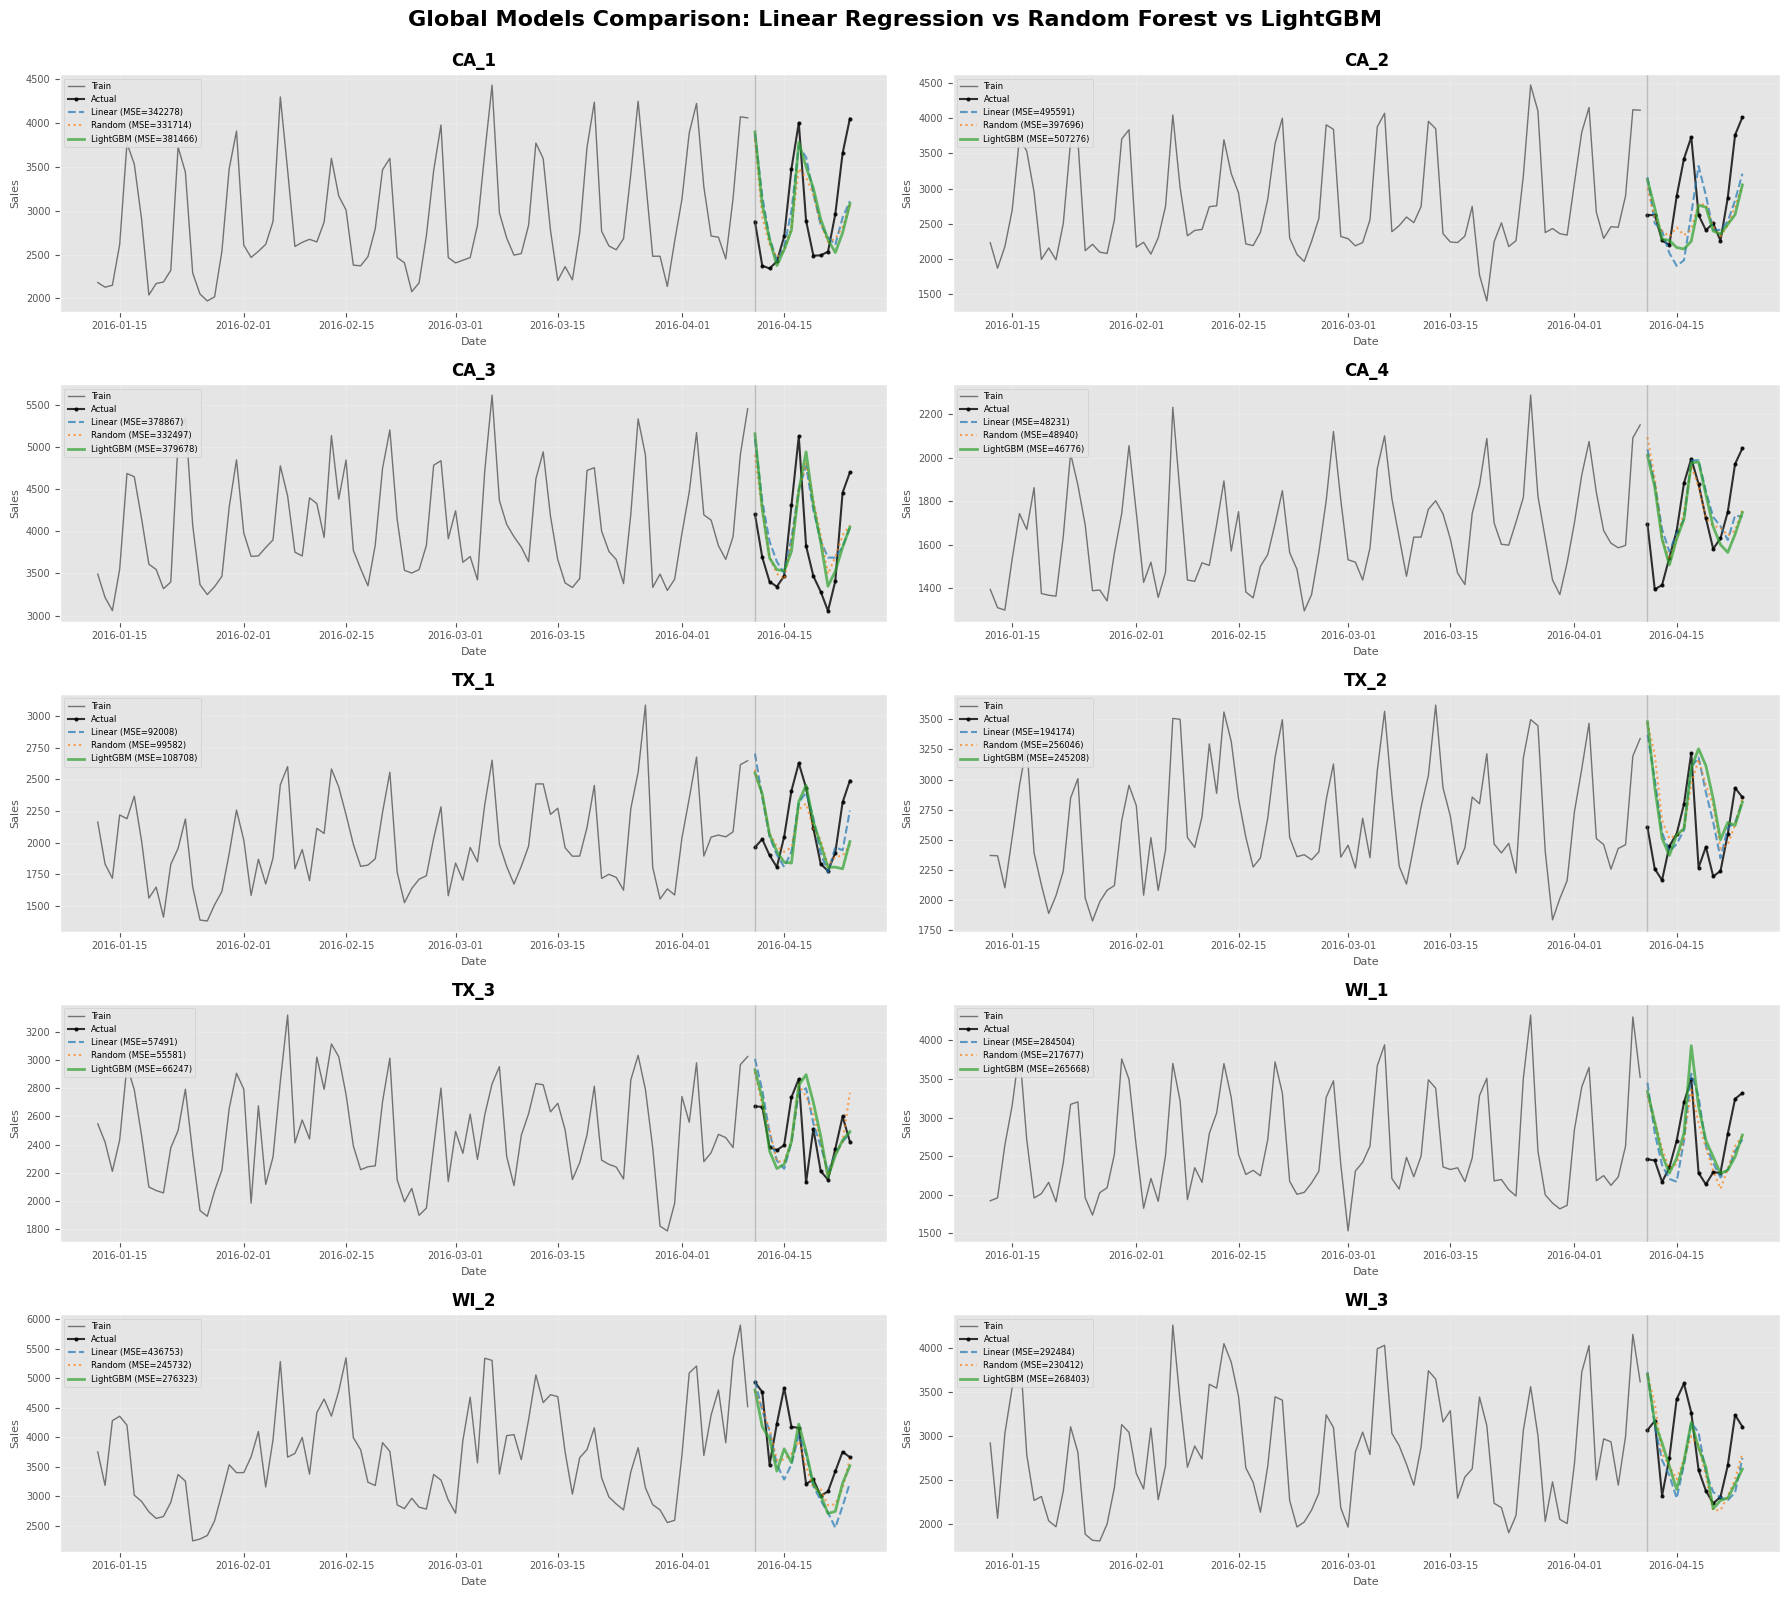


💡 Key Observations:
- Each model uses its optimal number of lags
- LightGBM (solid green) typically performs best
- All models trained on combined data from all stores


In [41]:
# Visualize all models for all stores
fig, axes = plt.subplots(5, 2, figsize=(18, 16))
axes = axes.flatten()

model_styles = {
    'Linear Regression': {'color': '#1f77b4', 'linestyle': '--', 'linewidth': 1.5},
    'Random Forest': {'color': '#ff7f0e', 'linestyle': ':', 'linewidth': 1.5},
    'LightGBM': {'color': '#2ca02c', 'linestyle': '-', 'linewidth': 2}
}

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store].sort_values('date')
    test_store = df_test[df_test['unique_id'] == store].sort_values('date')
    
    # Plot training data (last 90 days)
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['date'], train_context['y'], color='black', 
                   linewidth=1, alpha=0.5, label='Train')
    
    # Plot actual test data
    axes[idx].plot(test_store['date'], test_store['y'], color='black', 
                   linewidth=1.5, alpha=0.8, marker='o', markersize=2, label='Actual')
    
    # Plot forecasts for each model
    for model_name, forecasts in [('Linear Regression', forecasts_lr), 
                                    ('Random Forest', forecasts_rf),
                                    ('LightGBM', forecasts_lgbm)]:
        style = model_styles[model_name]
        mse = mse_comparison[model_name][store]
        axes[idx].plot(test_store['date'], forecasts[store], 
                      color=style['color'], linestyle=style['linestyle'], 
                      linewidth=style['linewidth'], alpha=0.7,
                      label=f"{model_name.split()[0]} (MSE={mse:.0f})")
    
    # Mark split
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.4)
    
    axes[idx].set_title(f"{store}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.2)
    axes[idx].legend(loc='upper left', fontsize=6, framealpha=0.9)

plt.suptitle('Global Models Comparison: Linear Regression vs Random Forest vs LightGBM',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("- Each model uses its optimal number of lags")
print("- LightGBM (solid green) typically performs best")
print("- All models trained on combined data from all stores")

## 6. Feature Engineering for LightGBM

Now let's improve LightGBM's performance with feature engineering!

We'll test four configurations:
1. **Baseline**: Just lagged features (what we already did)
2. **With Normalization**: StandardScaler on lag features
3. **With Date Features**: day_of_week, is_weekend, etc.
4. **With Both**: Normalization + Date Features

In [42]:
def add_date_features(df):
    """
    Add date-based features to dataframe.
    """
    df = df.copy()
    df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
    df['day_of_month'] = pd.to_datetime(df['date']).dt.day
    df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    return df

print("✅ Function created: add_date_features()")

✅ Function created: add_date_features()


In [48]:
def train_lgbm_with_features(df_train, df_test, max_lags, h, use_scaling=False, use_date_features=False):
    """
    Train LightGBM with optional feature engineering.
    """
    # Add date features if requested
    if use_date_features:
        df_train = add_date_features(df_train)
        df_test = add_date_features(df_test)
    
    # Create global training dataset
    train_lagged = create_global_training_dataset(df_train, max_lags=max_lags)
    
    # Add date features to lagged dataset
    date_feat_cols = []
    if use_date_features:
        date_cols = ['day_of_week', 'day_of_month', 'week_of_year', 'is_weekend']
        train_lagged = train_lagged.merge(
            df_train[['unique_id', 'date'] + date_cols], 
            on=['unique_id', 'date'], 
            how='left'
        )
        # Verify date features are present
        date_feat_cols = [col for col in date_cols if col in train_lagged.columns]
    
    # Prepare features
    lag_cols = [col for col in train_lagged.columns if col.startswith('lag_')]
    feature_cols = lag_cols + date_feat_cols
    
    X = train_lagged[feature_cols]
    y = train_lagged['target']
    
    # Apply scaling if requested
    scaler = None
    if use_scaling:
        scaler = StandardScaler()
        X_scaled = X.copy()
        X_scaled[lag_cols] = scaler.fit_transform(X[lag_cols])
        X = X_scaled
    
    # Train model
    model = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42, verbose=-1)
    model.fit(X, y)
    
    # Generate forecasts
    forecasts_dict = {}
    stores = df_train['unique_id'].unique()
    
    for store in stores:
        store_train = df_train[df_train['unique_id'] == store].sort_values('date')
        last_obs = store_train['y'].values[-max_lags:]
        last_date = store_train['date'].iloc[-1]
        
        history = list(last_obs)
        forecasts = []
        
        for step in range(h):
            # Lag features
            lag_features = np.array(history[-max_lags:]).reshape(1, -1)
            
            # Date features (only if they were used during training)
            if len(date_feat_cols) > 0:
                current_date = last_date + pd.Timedelta(days=step + 1)
                date_feats = np.array([[
                    current_date.dayofweek,
                    current_date.day,
                    current_date.isocalendar()[1],
                    1 if current_date.dayofweek >= 5 else 0
                ]])
                X_forecast = np.concatenate([lag_features, date_feats], axis=1)
            else:
                X_forecast = lag_features
            
            # Apply scaling if used
            if use_scaling and scaler is not None:
                X_forecast_scaled = X_forecast.copy()
                X_forecast_scaled[:, :max_lags] = scaler.transform(X_forecast[:, :max_lags])
                X_forecast = X_forecast_scaled
            
            y_pred = model.predict(X_forecast)[0]
            forecasts.append(y_pred)
            history.append(y_pred)
        
        forecasts_dict[store] = np.array(forecasts)
    
    return forecasts_dict

print("✅ Function created: train_lgbm_with_features()")

✅ Function created: train_lgbm_with_features()


In [49]:
# Test different feature engineering configurations
fe_configs = {
    'Baseline (no FE)': {'use_scaling': False, 'use_date_features': False},
    'With Scaling': {'use_scaling': True, 'use_date_features': False},
    'With Date Features': {'use_scaling': False, 'use_date_features': True},
    'With Both': {'use_scaling': True, 'use_date_features': True}
}

fe_forecasts = {}
fe_mse = {}

print("Testing feature engineering configurations for LightGBM...\n")
for config_name, config in fe_configs.items():
    print(f"  {config_name}...")
    fe_forecasts[config_name] = train_lgbm_with_features(
        df_train, df_test, max_lags=best_lags_lgbm, h=test_size, **config
    )
    
    # Calculate MSE
    fe_mse[config_name] = {}
    for store in stores:
        test_store = df_test[df_test['unique_id'] == store].sort_values('date')
        mse = mean_squared_error(test_store['y'].values, fe_forecasts[config_name][store])
        fe_mse[config_name][store] = mse

print("\n✅ Feature engineering comparison complete!")

Testing feature engineering configurations for LightGBM...

  Baseline (no FE)...


  With Scaling...
  With Date Features...
  With Both...

✅ Feature engineering comparison complete!


In [50]:
# Print MSE comparison for feature engineering
print("Feature Engineering Impact: MSE Comparison (LightGBM)")
print("=" * 100)
print(f"{'Store':<10} {'Baseline':<15} {'+ Scaling':<15} {'+ Date Feat':<15} {'+ Both':<15}")
print("-" * 100)

for store in stores:
    print(f"{store:<10} ", end='')
    for config_name in fe_configs.keys():
        print(f"{fe_mse[config_name][store]:<15.2f} ", end='')
    print()

# Average across stores
print("-" * 100)
print(f"{'Average':<10} ", end='')
for config_name in fe_configs.keys():
    avg_mse = np.mean(list(fe_mse[config_name].values()))
    print(f"{avg_mse:<15.2f} ", end='')
print()

# Calculate improvement
baseline_avg = np.mean(list(fe_mse['Baseline (no FE)'].values()))
best_avg = np.mean(list(fe_mse['With Both'].values()))
improvement = ((baseline_avg - best_avg) / baseline_avg) * 100

print(f"\n💡 Improvement: {improvement:.1f}% reduction in MSE with full feature engineering!")

Feature Engineering Impact: MSE Comparison (LightGBM)
Store      Baseline        + Scaling       + Date Feat     + Both         
----------------------------------------------------------------------------------------------------
CA_1       381466.06       244399.74       381466.06       244399.74       
CA_2       507275.71       447108.59       507275.71       447108.59       
CA_3       379677.83       327810.39       379677.83       327810.39       
CA_4       46776.34        91856.93        46776.34        91856.93        
TX_1       108708.21       108399.80       108708.21       108399.80       
TX_2       245208.07       148591.46       245208.07       148591.46       
TX_3       66246.87        69101.90        66246.87        69101.90        
WI_1       265668.05       244631.79       265668.05       244631.79       
WI_2       276322.69       376568.20       276322.69       376568.20       
WI_3       268402.62       227639.93       268402.62       227639.93       
----------

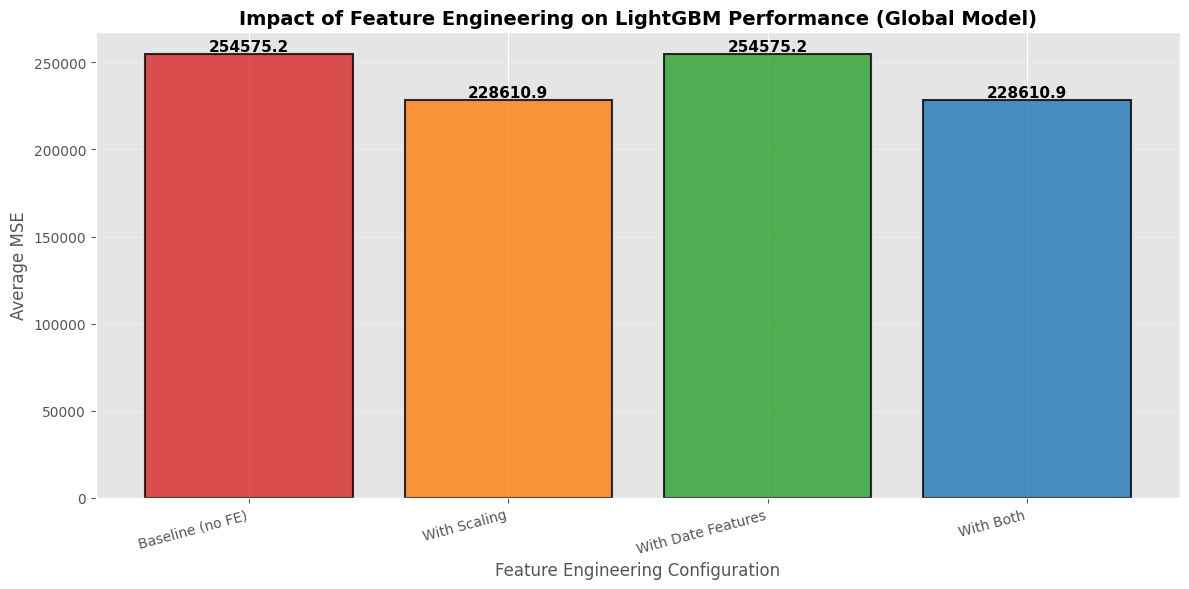

In [51]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

config_names = list(fe_configs.keys())
avg_mses = [np.mean(list(fe_mse[config].values())) for config in config_names]

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
bars = ax.bar(config_names, avg_mses, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mse in zip(bars, avg_mses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{mse:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Feature Engineering Configuration', fontsize=12)
ax.set_ylabel('Average MSE', fontsize=12)
ax.set_title('Impact of Feature Engineering on LightGBM Performance (Global Model)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 7. Loss Function Tuning for LightGBM

LightGBM supports different objective functions. Let's test which works best!

**Loss functions to test:**
- `regression` (L2, default) - Penalizes large errors heavily
- `regression_l1` (MAE) - Less sensitive to outliers
- `huber` - Robust to outliers (hybrid of L1 and L2)
- `fair` - Another robust option

We'll use the best feature engineering configuration from previous step.

In [52]:
def train_lgbm_with_loss(df_train, df_test, max_lags, h, objective='regression',
                         use_scaling=True, use_date_features=True):
    """
    Train LightGBM with specific loss function.
    """
    # Add date features
    if use_date_features:
        df_train = add_date_features(df_train)
        df_test = add_date_features(df_test)
    
    # Create global training dataset
    train_lagged = create_global_training_dataset(df_train, max_lags=max_lags)
    
    # Add date features to lagged dataset
    date_feat_cols = []
    if use_date_features:
        date_cols = ['day_of_week', 'day_of_month', 'week_of_year', 'is_weekend']
        train_lagged = train_lagged.merge(
            df_train[['unique_id', 'date'] + date_cols], 
            on=['unique_id', 'date'], 
            how='left'
        )
        # Verify date features are present
        date_feat_cols = [col for col in date_cols if col in train_lagged.columns]
    
    # Prepare features
    lag_cols = [col for col in train_lagged.columns if col.startswith('lag_')]
    feature_cols = lag_cols + date_feat_cols
    
    X = train_lagged[feature_cols]
    y = train_lagged['target']
    
    # Apply scaling
    scaler = None
    if use_scaling:
        scaler = StandardScaler()
        X_scaled = X.copy()
        X_scaled[lag_cols] = scaler.fit_transform(X[lag_cols])
        X = X_scaled
    
    # Train model with specified objective
    model = lgb.LGBMRegressor(
        objective=objective, 
        random_state=42, 
        verbose=-1
    )
    model.fit(X, y)
    
    # Generate forecasts
    forecasts_dict = {}
    stores = df_train['unique_id'].unique()
    
    for store in stores:
        store_train = df_train[df_train['unique_id'] == store].sort_values('date')
        last_obs = store_train['y'].values[-max_lags:]
        last_date = store_train['date'].iloc[-1]
        
        history = list(last_obs)
        forecasts = []
        
        for step in range(h):
            lag_features = np.array(history[-max_lags:]).reshape(1, -1)
            
            # Date features (only if they were used during training)
            if len(date_feat_cols) > 0:
                current_date = last_date + pd.Timedelta(days=step + 1)
                date_feats = np.array([[
                    current_date.dayofweek,
                    current_date.day,
                    current_date.isocalendar()[1],
                    1 if current_date.dayofweek >= 5 else 0
                ]])
                X_forecast = np.concatenate([lag_features, date_feats], axis=1)
            else:
                X_forecast = lag_features
            
            if use_scaling and scaler is not None:
                X_forecast_scaled = X_forecast.copy()
                X_forecast_scaled[:, :max_lags] = scaler.transform(X_forecast[:, :max_lags])
                X_forecast = X_forecast_scaled
            
            y_pred = model.predict(X_forecast)[0]
            forecasts.append(y_pred)
            history.append(y_pred)
        
        forecasts_dict[store] = np.array(forecasts)
    
    return forecasts_dict

print("✅ Function created: train_lgbm_with_loss()")

✅ Function created: train_lgbm_with_loss()


In [67]:
# Test different loss functions
loss_functions = ['mae', 'mape', 'rmse', 'huber']
loss_forecasts = {}
loss_mse = {}

print("Testing different loss functions for LightGBM...\n")
for loss_fn in loss_functions:
    print(f"  Training with {loss_fn}...")
    loss_forecasts[loss_fn] = train_lgbm_with_loss(
        df_train, df_test, max_lags=best_lags_lgbm, h=test_size, 
        objective=loss_fn, use_scaling=True, use_date_features=True
    )
    
    # Calculate MSE
    loss_mse[loss_fn] = {}
    for store in stores:
        test_store = df_test[df_test['unique_id'] == store].sort_values('date')
        mse = mean_squared_error(test_store['y'].values, loss_forecasts[loss_fn][store])
        loss_mse[loss_fn][store] = mse

print("\n✅ Loss function comparison complete!")

Testing different loss functions for LightGBM...

  Training with mae...
  Training with mape...
  Training with rmse...
  Training with huber...

✅ Loss function comparison complete!


In [68]:
# Print MSE comparison for loss functions
print("Loss Function Impact: MSE Comparison (LightGBM with Full FE)")
print("=" * 90)
print(f"{'Store':<10} {'mae':<20} {'mape':<20} {'rmse':<20} {'huber':<20}")
print("-" * 90)

for store in stores:
    print(f"{store:<10} ", end='')
    for loss_fn in loss_functions:
        print(f"{loss_mse[loss_fn][store]:<20.2f} ", end='')
    print()

# Average across stores
print("-" * 90)
print(f"{'Average':<10} ", end='')
avg_loss_mse = {}
for loss_fn in loss_functions:
    avg_mse = np.mean(list(loss_mse[loss_fn].values()))
    avg_loss_mse[loss_fn] = avg_mse
    print(f"{avg_mse:<20.2f} ", end='')
print()

# Find best loss function
best_loss = min(avg_loss_mse, key=avg_loss_mse.get)
print(f"\n✅ Best loss function: {best_loss}")
print(f"   Average MSE: {avg_loss_mse[best_loss]:.2f}")

Loss Function Impact: MSE Comparison (LightGBM with Full FE)
Store      mae                  mape                 rmse                 huber               
------------------------------------------------------------------------------------------
CA_1       292500.29            854128.19            243901.37            542985.63            
CA_2       517394.53            1581498.74           426117.05            487862.75            
CA_3       261423.13            1517399.58           309214.29            2156928.34           
CA_4       115713.64            124151.46            87172.63             617002.59            
TX_1       104927.01            141383.80            106440.28            208580.07            
TX_2       125949.68            133479.76            132592.12            93657.81             
TX_3       59572.44             58666.95             64002.15             45632.95             
WI_1       263787.94            270634.95            249959.23            230357.

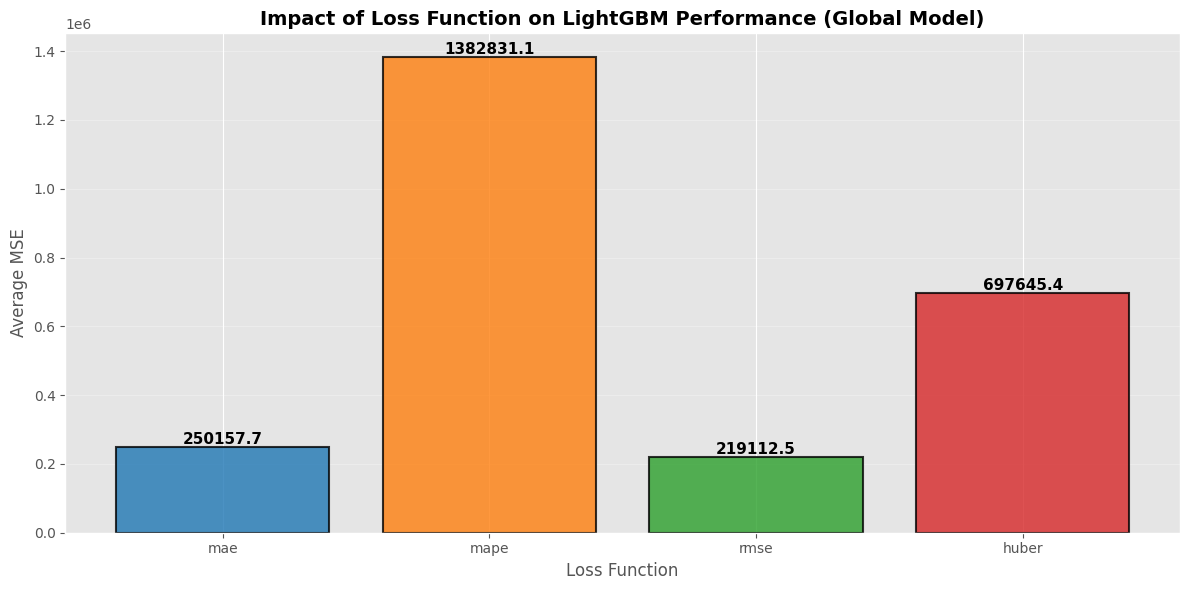

In [69]:
# Bar chart for loss function comparison
fig, ax = plt.subplots(figsize=(12, 6))

loss_names = loss_functions
avg_mses = [avg_loss_mse[loss] for loss in loss_names]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(loss_names, avg_mses, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mse in zip(bars, avg_mses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{mse:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Loss Function', fontsize=12)
ax.set_ylabel('Average MSE', fontsize=12)
ax.set_title('Impact of Loss Function on LightGBM Performance (Global Model)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 8. Final Comparison and Summary

Let's visualize the best configuration (LightGBM with best loss function + full FE) for all stores!

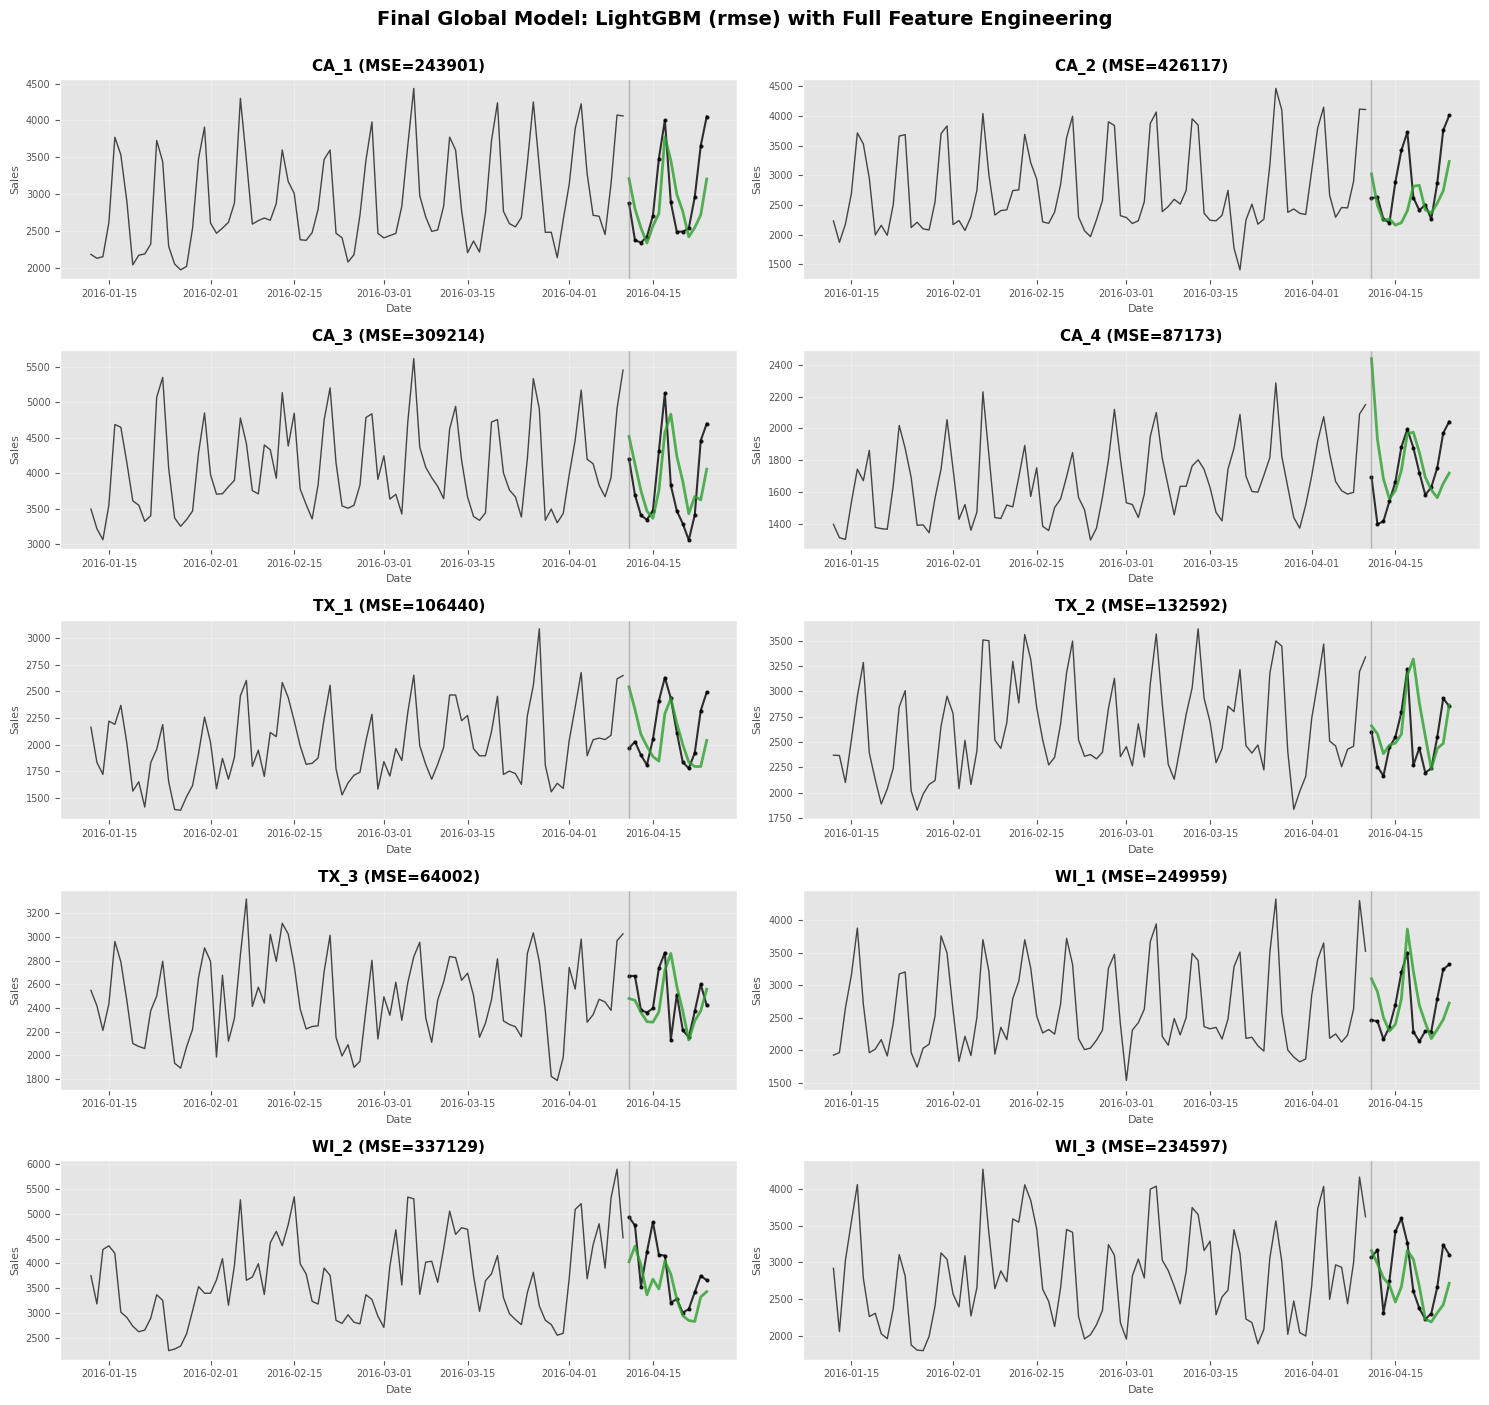


✅ Final Model Performance:
   Average MSE across all stores: 219112.46
   Model: LightGBM with rmse loss
   Features: Lags + Normalization + Date Features
   Optimal lags: 28


In [70]:
# Visualize final best model for all stores
fig, axes = plt.subplots(5, 2, figsize=(15, 14))
axes = axes.flatten()

for idx, store in enumerate(stores):
    train_store = df_train[df_train['unique_id'] == store].sort_values('date')
    test_store = df_test[df_test['unique_id'] == store].sort_values('date')
    forecast = loss_forecasts[best_loss][store]
    
    # Plot
    train_context = train_store.tail(90)
    axes[idx].plot(train_context['date'], train_context['y'], 
                   color='black', linewidth=1, alpha=0.7)
    axes[idx].plot(test_store['date'], test_store['y'], 
                   color='black', linewidth=1.5, alpha=0.8, marker='o', markersize=2)
    axes[idx].plot(test_store['date'], forecast, 
                   color='#2ca02c', linewidth=2, linestyle='-', alpha=0.8)
    axes[idx].axvline(x=split_date, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    # Calculate MSE
    mse = loss_mse[best_loss][store]
    
    axes[idx].set_title(f"{store} (MSE={mse:.0f})", fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=8)
    axes[idx].set_ylabel('Sales', fontsize=8)
    axes[idx].tick_params(labelsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle(f'Final Global Model: LightGBM ({best_loss}) with Full Feature Engineering',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

avg_mse_final = avg_loss_mse[best_loss]
print(f"\n✅ Final Model Performance:")
print(f"   Average MSE across all stores: {avg_mse_final:.2f}")
print(f"   Model: LightGBM with {best_loss} loss")
print(f"   Features: Lags + Normalization + Date Features")
print(f"   Optimal lags: {best_lags_lgbm}")

## 9. Summary and Key Takeaways

### What We Learned in Session 3:

#### 1. **Global ML Models**
- Train **one model across all time series**
- Learns cross-series patterns
- More scalable than local models
- Better data efficiency

#### 2. **Global Data Preparation**
- Create lagged features for each series
- **Stack** all series into one dataset
- Keep `unique_id` to track series identity

#### 3. **Model-Specific Lag Selection**
- Different models prefer different lag configurations
- Use time series CV to find optimal lags per model
- Test candidates: [3, 7, 14, 21, 28]

#### 4. **Model Comparison**
- **Linear Regression**: Simple baseline, fast
- **Random Forest**: Captures non-linear patterns
- **LightGBM**: Best performance, handles complex relationships

#### 5. **Feature Engineering (LightGBM)**
- **Normalization**: StandardScaler improves convergence
- **Date Features**: Captures calendar effects (weekends, day of week)
- **Combined**: Best performance!

#### 6. **Loss Function Tuning**
- Tested: `regression`, `regression_l1`, `huber`, `fair`
- Different objectives for different data characteristics
- Robust losses (huber, fair) handle outliers better

### Global vs Local Models:

| Aspect | Local Models | Global Models |
|--------|--------------|---------------|
| Training | One model per series | One model for all series |
| Data | Series-specific only | Cross-series learning |
| Scalability | N models for N series | 1 model for N series |
| Best for | Long individual series | Short series, many series |

### Key Principles:

1. **Global models scale better** - especially for many time series
2. **Model-specific tuning** - find optimal lags for each algorithm
3. **Feature engineering matters** - normalization + date features boost performance
4. **Loss function selection** - choose based on data characteristics
5. **Cross-series learning** - global models leverage patterns across series

---

### 🎓 Congratulations!

You've completed Session 3 of the Time Series Forecasting Workshop. You now understand:
- Global machine learning models
- Model-specific hyperparameter tuning
- Advanced feature engineering
- Loss function optimization

**Next steps**: Explore deep learning approaches (RNNs, LSTMs, Transformers) for even more powerful forecasting! 🚀